In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
from google.colab import files


uploaded = files.upload()

Saving LSTM_train_week4.csv to LSTM_train_week4.csv


In [4]:
file1 = 'LSTM_train_week4.csv'
data = pd.read_csv(file1, nrows=505)
data

,Date,Price,Open,High,Low,Volume,Chg%
0,04-Jan-21,47.62,48.40,49.83,47.18,528.53K,-1.85%
1,05-Jan-21,49.93,47.38,50.20,47.24,643.19K,4.85%
2,06-Jan-21,50.63,49.82,50.94,49.48,509.37K,1.40%
3,07-Jan-21,50.83,50.53,51.28,50.39,369.29K,0.40%
4,08-Jan-21,52.24,50.93,52.75,50.81,499.42K,2.77%
...,...,...,...,...,...,...,...
500,23-Nov-22,77.94,81.08,81.95,76.83,379.15K,-3.72%
501,24-Nov-22,77.95,77.53,78.19,76.92,0,0.01%
502,25-Nov-22,76.28,77.51,79.90,76.22,266.45K,-2.14%
503,28-Nov-22,77.24,75.93,77.84,73.60,405.03K,1.26%


In [5]:
data=data[["Date","Price"]]

In [6]:
data["Date"]=pd.to_datetime(data["Date"])

<ipython-input-6-cde8a6fe7fd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"]=pd.to_datetime(data["Date"])


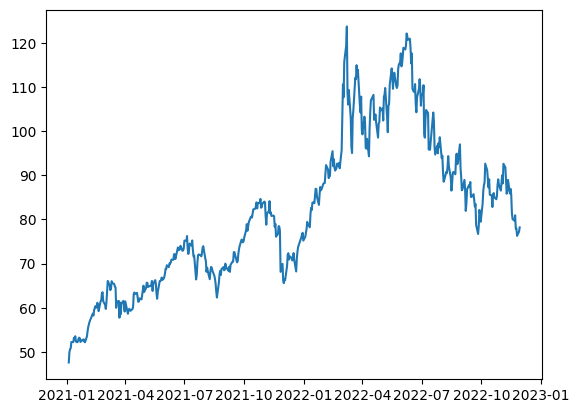

In [7]:
plt.plot(data["Date"],data["Price"])

In [8]:
from copy import deepcopy as dc
def shifted(df,n):
  df=dc(df)
  df.set_index("Date",inplace=True)
  for i in range(1,n+1):
    df[f'Price(t-{i})']=df['Price'].shift(i)
  df.dropna(inplace=True)

  return df
shifted_df=shifted(data,7)
shifted_df


,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
2021-01-13,52.91,53.21,52.25,52.24,50.83,50.63,49.93,47.62
2021-01-14,53.57,52.91,53.21,52.25,52.24,50.83,50.63,49.93
2021-01-15,52.36,53.57,52.91,53.21,52.25,52.24,50.83,50.63
2021-01-17,52.20,52.36,53.57,52.91,53.21,52.25,52.24,50.83
2021-01-18,52.36,52.20,52.36,53.57,52.91,53.21,52.25,52.24
...,...,...,...,...,...,...,...,...
2022-11-23,77.94,80.95,79.73,80.08,81.64,85.59,86.92,85.87
2022-11-24,77.95,77.94,80.95,79.73,80.08,81.64,85.59,86.92
2022-11-25,76.28,77.95,77.94,80.95,79.73,80.08,81.64,85.59


In [9]:
df=shifted_df.to_numpy()

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler=MinMaxScaler(feature_range=(-1,1))
df=scaler.fit_transform(df)
df

array([[-0.98013986, -0.97174825, -0.9986014 , ..., -1.        ,
        -1.        , -1.        ],
       [-0.96167832, -0.98013986, -0.97174825, ..., -0.9945258 ,
        -0.9810221 , -0.93927445],
       [-0.99552448, -0.96167832, -0.98013986, ..., -0.95593267,
        -0.97559984, -0.92087277],
       ...,
       [-0.32643357, -0.27972028, -0.28      , ..., -0.19392363,
        -0.14030094, -0.00184017],
       [-0.29958042, -0.32643357, -0.27972028, ..., -0.20350349,
        -0.18259455, -0.10567823],
       [-0.27272727, -0.29958042, -0.32643357, ..., -0.17011085,
        -0.1920835 , -0.1466877 ]])

In [12]:
X=df[:,1:]
y=df[:,0]
X.shape,y.shape

((498, 7), (498,))

In [15]:
X_train=dc(np.flip(X,axis=1))
X_train.shape

(498, 7)

In [16]:
X_train=X_train.reshape((-1,7,1))
y_train=y.reshape((-1,1))
X_train.shape

(498, 7, 1)

In [17]:
X_train=torch.tensor(X_train).float()
y_train=torch.tensor(y_train).float()


In [18]:
device='cpu'
from torch.utils.data import Dataset, DataLoader

class PredictionDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    x=torch.tensor(self.X[i],dtype=torch.float32)
    y=torch.tensor(self.y[i],dtype=torch.float32)
    return x,y

train_dataset = PredictionDataset(X_train,y_train)
train_dataset

In [19]:
batch_size=16

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
device='cpu'
train_loader


In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


<ipython-input-18-9d51847bb3d2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(self.X[i],dtype=torch.float32)
<ipython-input-18-9d51847bb3d2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(self.y[i],dtype=torch.float32)


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to('cpu')
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = rmse(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = rmse(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
def rmse(y_true, y_pred):
    return torch.sqrt(loss_function(y_true, y_pred))

In [26]:
learning_rate = 0.001
num_epochs = 45

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    #validate_one_epoch()

Epoch: 1

Epoch: 2


<ipython-input-18-9d51847bb3d2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(self.X[i],dtype=torch.float32)
<ipython-input-18-9d51847bb3d2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(self.y[i],dtype=torch.float32)



Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39

Epoch: 40

Epoch: 41

Epoch: 42

Epoch: 43

Epoch: 44

Epoch: 45



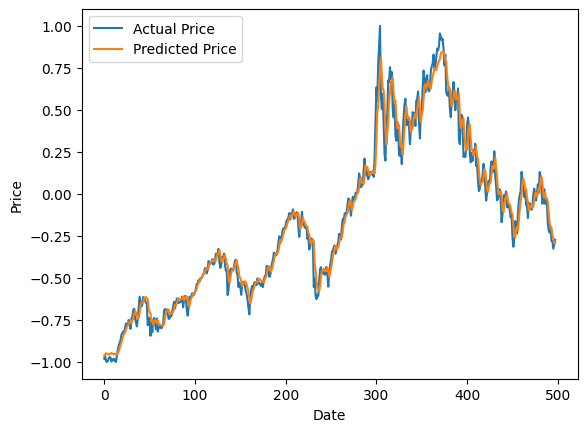

In [85]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [86]:
train_predictions1 = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 8))
dummies[:, 0] = train_predictions1
dummies = scaler.inverse_transform(dummies)

train_predictions1 = dc(dummies[:, 0])
train_predictions1

array([ 53.48884155,  53.74843004,  54.05385133,  53.95096886,
        53.82139729,  53.7572774 ,  53.87189455,  54.01112321,
        54.08193615,  53.90258754,  53.91220841,  53.88788457,
        53.92773176,  53.82190017,  53.70874905,  53.97072625,
        54.49316559,  55.11645031,  55.71284349,  56.31066861,
        57.08814279,  57.76058659,  58.30485026,  58.49436097,
        59.03535589,  59.71434571,  60.05349648,  60.24426439,
        60.77505886,  60.87192377,  60.45690991,  61.03177921,
        61.44336451,  62.35132441,  63.0587421 ,  62.66121199,
        62.09567588,  61.40355567,  61.53268829,  62.60969405,
        64.24060778,  64.8378597 ,  64.79666154,  64.95642109,
        65.72447045,  65.95447187,  65.98662664,  65.72945241,
        65.5084603 ,  63.4479661 ,  62.88973246,  62.50318484,
        60.78925469,  61.06006007,  60.18008057,  60.56892954,
        61.09721598,  61.04216079,  60.48942905,  61.0657921 ,
        60.29541157,  60.1231481 ,  60.11559418,  60.04

In [87]:
dummies = np.zeros((X_train.shape[0], 8))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 52.91000031,  53.56999984,  52.36000034,  52.2       ,
        52.36000034,  52.97999926,  53.23999901,  53.12999944,
        52.26999895,  52.77000028,  52.60999994,  52.84999938,
        52.34000003,  52.2       ,  53.54999953,  54.75999903,
        55.69000061,  56.23000042,  56.84999934,  57.96999958,
        58.35999921,  58.67999988,  58.23999949,  59.4699993 ,
        60.3700004 ,  60.09000034,  60.04999973,  61.13999951,
        60.52000059,  59.24000001,  61.49000065,  61.66999916,
        63.21999965,  63.53000018,  61.5000008 ,  60.64000031,
        59.74999936,  61.27999954,  63.83000055,  66.08999921,
        65.0500002 ,  64.00999906,  64.43999931,  66.02000026,
        65.61000032,  65.38999906,  64.8000006 ,  64.59999965,
        59.99999895,  61.41999957,  61.54999944,  57.7600006 ,
        61.18000012,  58.56000016,  60.96999901,  61.5599996 ,
        60.55000105,  59.1600009 ,  61.45000003,  58.64999942,
        59.32999927,  59.76999967,  59.59999917,  59.31

In [89]:
X=dc(np.flip(X,axis=0))
X=X.reshape((-1,7,1))
y=y.reshape((-1,1))
X=torch.tensor(X).float()
y=torch.tensor(y).float()
X.dtype

torch.float32

In [90]:
test_predictions = model(X.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X.shape[0], 8))
dummies[:, 0] = test_predictions
print(dummies)
dummies = scaler.inverse_transform(dummies)
print(dummies)

test_predictions = dc(dummies[0,0])
test_predictions

[[-0.1674737   0.          0.         ...  0.          0.
   0.        ]
 [-0.1422067   0.          0.         ...  0.          0.
   0.        ]
 [-0.0734418   0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.9365204   0.          0.         ...  0.          0.
   0.        ]
 [-0.94832534  0.          0.         ...  0.          0.
   0.        ]
 [-0.97043121  0.          0.         ...  0.          0.
   0.        ]]
[[81.9628151  87.95       87.95       ... 87.165      86.815
  85.66      ]
 [82.86611052 87.95       87.95       ... 87.165      86.815
  85.66      ]
 [85.32445553 87.95       87.95       ... 87.165      86.815
  85.66      ]
 ...
 [54.46939578 87.95       87.95       ... 87.165      86.815
  85.66      ]
 [54.04736924 87.95       87.95       ... 87.165      86.815
  85.66      ]
 [53.25708429 87.95       87.95       ... 87.165      86.815
  85.66      ]]


81.96281509548427

In [91]:
data_original = pd.read_csv(file1)
data_original

,Date,Price,Open,High,Low,Volume,Chg%
0,04-Jan-21,47.62,48.40,49.83,47.18,528.53K,-1.85%
1,05-Jan-21,49.93,47.38,50.20,47.24,643.19K,4.85%
2,06-Jan-21,50.63,49.82,50.94,49.48,509.37K,1.40%
3,07-Jan-21,50.83,50.53,51.28,50.39,369.29K,0.40%
4,08-Jan-21,52.24,50.93,52.75,50.81,499.42K,2.77%
...,...,...,...,...,...,...,...
530,25-Dec-22,NaN,NaN,NaN,NaN,NaN,NaN
531,26-Dec-22,NaN,NaN,NaN,NaN,NaN,NaN
532,27-Dec-22,NaN,NaN,NaN,NaN,NaN,NaN
533,28-Dec-22,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
data_original=data_original[['Date','Price']]
data_original["Date"]=pd.to_datetime(data["Date"])

<ipython-input-92-08d9c1aa2bbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original["Date"]=pd.to_datetime(data["Date"])


In [93]:
data_original['Price'][504]
data_original.iloc[505]

Date     NaT
Price    NaN
Name: 505, dtype: object

In [94]:
for _ in range(1,31):
  data_original['Date'][_+504]=_

<ipython-input-94-858a883fe385>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original['Date'][_+504]=_


In [97]:
predicted_prices=[]
for k in range(1,8):
    data_original[f'Price(t-{k})']=data_original['Price'][k]
for i in range(505,535):
  for k in range(1,8):
    data_original[f'Price(t-{k})'][i]=data_original['Price'][i-k]
  test=data_original.iloc[i:i+1]
  print(test)
  test=test.to_numpy()
  print(test)
  Xt=test[:,1:]
  Xt=scaler.transform(Xt)

  Xt=Xt[:,1:]
  print('hello',Xt)

  #yt=test[:,1]
  Xtest=dc(np.flip(Xt,axis=1))
  X_test=Xtest.reshape((-1,7,1))
  #y_test=yt.reshape((-1,1))
  X_test=torch.tensor(X_test).float()
  #y_test=torch.tensor(y_test).float()
  with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()
    print(predicted)
  train_predictions = predicted.flatten()

  dummies = np.zeros((X_test.shape[0], 8))
  dummies[:, 0] = train_predictions
  dummies = scaler.inverse_transform(dummies)

  train_predictions = dc(dummies[:, 0])
  print(train_predictions)
  data_original['Price'][i]=train_predictions[0]
  predicted_prices.append(train_predictions[0])











<ipython-input-97-9cbb9c2ab449>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original[f'Price(t-{k})']=data_original['Price'][k]
<ipython-input-97-9cbb9c2ab449>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original[f'Price(t-{k})']=data_original['Price'][k]
<ipython-input-97-9cbb9c2ab449>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

    Date  Price  Price(t-1)  Price(t-2)  Price(t-3)  Price(t-4)  Price(t-5)  \
505    1    NaN        78.2       77.24       76.28       77.95       77.94   

     Price(t-6)  Price(t-7)  
505       80.95       79.73  
[[1 nan 78.2 77.24 76.28 77.95 77.94 80.95 79.73]]
hello [[-0.27272727 -0.29958042 -0.32643357 -0.25566077 -0.25249761 -0.15900773
  -0.15588854]]
[[-0.28089258]]
[77.90809024]
    Date  Price  Price(t-1)  Price(t-2)  Price(t-3)  Price(t-4)  Price(t-5)  \
506    2    NaN    77.90809        78.2       77.24       76.28       77.95   

     Price(t-6)  Price(t-7)  
506       77.94       80.95  
[[2 nan 77.90809023827316 78.2 77.24 76.28 77.95 77.94 80.95]]
hello [[-0.28089258 -0.27272727 -0.29958042 -0.30149581 -0.25222389 -0.24061272
  -0.12381703]]
[[-0.27846348]]
[77.99493049]
    Date  Price  Price(t-1)  Price(t-2)  Price(t-3)  Price(t-4)  Price(t-5)  \
507    3    NaN    77.99493    77.90809        78.2       77.24       76.28   

     Price(t-6)  Price(t-7)  
507    

<ipython-input-97-9cbb9c2ab449>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original['Price'][i]=train_predictions[0]
<ipython-input-97-9cbb9c2ab449>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original[f'Price(t-{k})'][i]=data_original['Price'][i-k]
<ipython-input-97-9cbb9c2ab449>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_original['Price'][i]=train_predictions[0]
<ipython-input-97-9cbb9c2ab449>:6: Set

In [98]:
predicted_prices

[77.90809023827316,
 77.99493048787119,
 78.11714737564327,
 78.23124246746303,
 78.34130596071483,
 78.44094419181349,
 78.53891502022745,
 78.63785219639541,
 78.73430797904732,
 78.82875755131246,
 78.92144596278669,
 79.01246377527715,
 79.10187811106445,
 79.18971986770632,
 79.27603166252376,
 79.36087848693134,
 79.44430508911611,
 79.52635941356422,
 79.60708620846273,
 79.68653022199871,
 79.76473300606014,
 79.84173717796804,
 79.91758109331133,
 79.99230417311193,
 80.0659415766597,
 80.13853165954353,
 80.2101021230221,
 80.28069345355036,
 80.35033228695394,
 80.41905271708967]

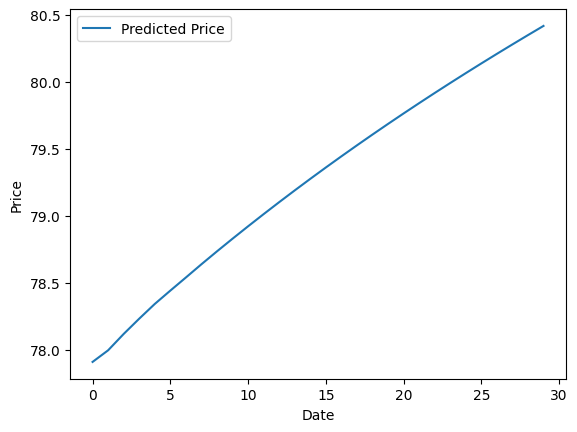

In [99]:
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [100]:
l=np.concatenate((train_predictions1, predicted_prices))
l

array([ 53.48884155,  53.74843004,  54.05385133,  53.95096886,
        53.82139729,  53.7572774 ,  53.87189455,  54.01112321,
        54.08193615,  53.90258754,  53.91220841,  53.88788457,
        53.92773176,  53.82190017,  53.70874905,  53.97072625,
        54.49316559,  55.11645031,  55.71284349,  56.31066861,
        57.08814279,  57.76058659,  58.30485026,  58.49436097,
        59.03535589,  59.71434571,  60.05349648,  60.24426439,
        60.77505886,  60.87192377,  60.45690991,  61.03177921,
        61.44336451,  62.35132441,  63.0587421 ,  62.66121199,
        62.09567588,  61.40355567,  61.53268829,  62.60969405,
        64.24060778,  64.8378597 ,  64.79666154,  64.95642109,
        65.72447045,  65.95447187,  65.98662664,  65.72945241,
        65.5084603 ,  63.4479661 ,  62.88973246,  62.50318484,
        60.78925469,  61.06006007,  60.18008057,  60.56892954,
        61.09721598,  61.04216079,  60.48942905,  61.0657921 ,
        60.29541157,  60.1231481 ,  60.11559418,  60.04

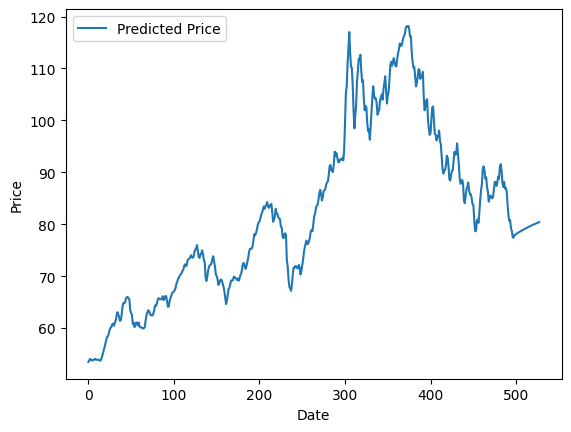

In [102]:
plt.plot(l, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [103]:
# FINAL ANSWER
print('PREDICTED PRICES FOR NEXT 30 DAYS')
for i in range(30):
  print(f'DAY {i+1} - {predicted_prices[i]} ')


PREDICTED PRICES FOR NEXT 30 DAYS
DAY 1 - 77.90809023827316 
DAY 2 - 77.99493048787119 
DAY 3 - 78.11714737564327 
DAY 4 - 78.23124246746303 
DAY 5 - 78.34130596071483 
DAY 6 - 78.44094419181349 
DAY 7 - 78.53891502022745 
DAY 8 - 78.63785219639541 
DAY 9 - 78.73430797904732 
DAY 10 - 78.82875755131246 
DAY 11 - 78.92144596278669 
DAY 12 - 79.01246377527715 
DAY 13 - 79.10187811106445 
DAY 14 - 79.18971986770632 
DAY 15 - 79.27603166252376 
DAY 16 - 79.36087848693134 
DAY 17 - 79.44430508911611 
DAY 18 - 79.52635941356422 
DAY 19 - 79.60708620846273 
DAY 20 - 79.68653022199871 
DAY 21 - 79.76473300606014 
DAY 22 - 79.84173717796804 
DAY 23 - 79.91758109331133 
DAY 24 - 79.99230417311193 
DAY 25 - 80.0659415766597 
DAY 26 - 80.13853165954353 
DAY 27 - 80.2101021230221 
DAY 28 - 80.28069345355036 
DAY 29 - 80.35033228695394 
DAY 30 - 80.41905271708967 
